In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [3]:
df = pd.read_csv("data/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Eksplorasi Dataset

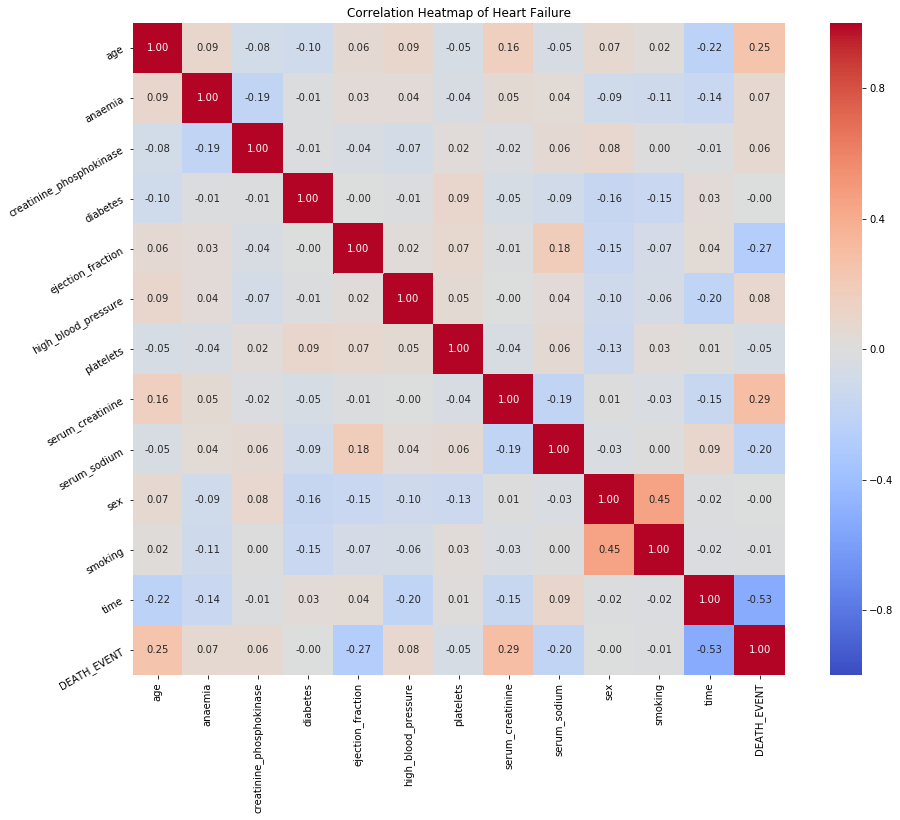

In [4]:
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Heart Failure')
a = sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, linecolor='white', cmap= 'coolwarm')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

bisa kita lihat disini age dan serum creatinine cukup berkorelasi kuat dengan target, maka mungkin keduanya merupakan fitur yang cukup penting dan fitur time berkorelasi lemah dengan target, ini bisa jadi pertimbangan untuk kita drop.

Gambar histogram dari `age`

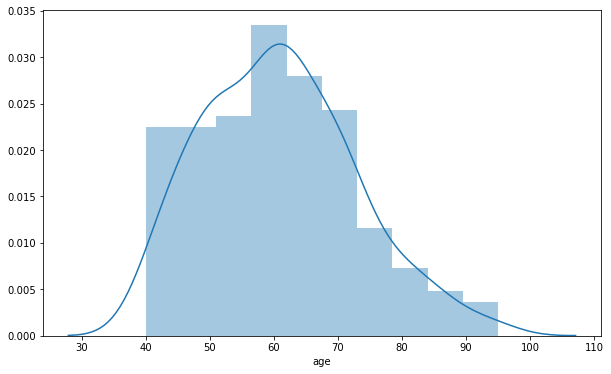

In [5]:
f, ax = plt.subplots(figsize=(10,6))
x = df["age"]
ax = sns.distplot(x, bins=10)
plt.show()

Metrik yang kita gunakan untuk uji normalitas ini adalah uji Jarque Bera. Untuk sampel yang lebih besar dari 200 selain menggunakan Jarque Bera, kita juga bisa mempunyai alternatif lain seperti uji Skewness Kurtosis. Tetapi disini saya menggunakan Uji Jarque Bera karena cocok untuk mengukur apakah skewness sesuai dengan distribusi normal.

In [6]:
stat, p = st.jarque_bera(df.age)
stat, p

(9.337159006323436, 0.009385592266451082)

Berdasarkan uji jarque bera, diperoleh p-value = 0.009 < α = 0.05. Dengan menggunakan tingkat kepercayaan 95%, data yang ada mendukung bahwa data tidak berdistribusi normal. Maka nanti data tersebut bisa kita transform.

Dengan asumsi bahwa variabel `serum_sodium` terdistribusi Gaussian, maka berapa peluang mengobservasi nilainya lebih dari 140?

In [7]:
pd.set_option("display.precision", 4)
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000
mean,60.8339,0.4314,581.8395,0.4181,38.0836,0.3512,263358.0293,1.3939,136.6254,0.6488,0.3211,130.2609,0.3211
std,11.8948,0.4961,970.2879,0.4941,11.8348,0.4781,97804.2369,1.0345,4.4125,0.4781,0.4677,77.6142,0.4677
min,40.0000,0.0000,23.0000,0.0000,14.0000,0.0000,25100.0000,0.5000,113.0000,0.0000,0.0000,4.0000,0.0000
25%,51.0000,0.0000,116.5000,0.0000,30.0000,0.0000,212500.0000,0.9000,134.0000,0.0000,0.0000,73.0000,0.0000
50%,60.0000,0.0000,250.0000,0.0000,38.0000,0.0000,262000.0000,1.1000,137.0000,1.0000,0.0000,115.0000,0.0000
75%,70.0000,1.0000,582.0000,1.0000,45.0000,1.0000,303500.0000,1.4000,140.0000,1.0000,1.0000,203.0000,1.0000
max,95.0000,1.0000,7861.0000,1.0000,80.0000,1.0000,850000.0000,9.4000,148.0000,1.0000,1.0000,285.0000,1.0000


'Peluang: 0.18023546451440786'

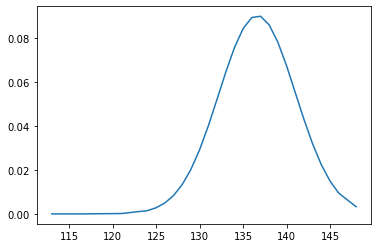

In [8]:
from scipy.stats import norm

mean = df.serum_sodium.mean() #mean
std = df.serum_sodium.std() #standard deviasi
dist = norm(mean, std) #distribusi gaussian normal atau normal distribution

serums = df.serum_sodium.values
serums.sort()
values = [value for value in serums]
#hitung probabilitynya (zscore)
probabilities = [dist.pdf(value) for value in serums]

plt.plot(values, probabilities);

#filter yg lebih dari 140
serums = df.serum_sodium[df.serum_sodium > 140].unique()
probabilities = [dist.pdf(value) for value in serums]
f"Peluang: {np.sum(probabilities)}"

### cek target

In [9]:
df["DEATH_EVENT"].value_counts() / len(df)

0    0.6789
1    0.3211
Name: DEATH_EVENT, dtype: float64

In [10]:
df["DEATH_EVENT"].unique()

array([1, 0], dtype=int64)

In [11]:
df.groupby("DEATH_EVENT").mean()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
DEATH_EVENT,,,,,,,,,,,,
0,58.7619,0.4089,540.0542,0.4187,40.2660,0.3251,266657.4899,1.1849,138.2611,0.6502,0.3251,158.3399
1,65.2153,0.4792,670.1979,0.4167,33.4688,0.4062,256381.0448,1.8358,133.1667,0.6458,0.3125,70.8854


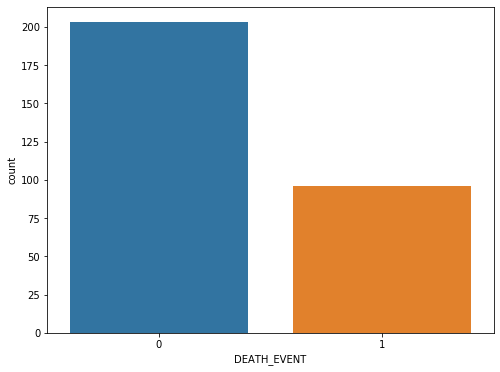

In [12]:
#kita lihat distribusi target
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="DEATH_EVENT", data=df)
plt.show()

Kurang lebih ada setengahnya yang meninggal karena gagal jantung

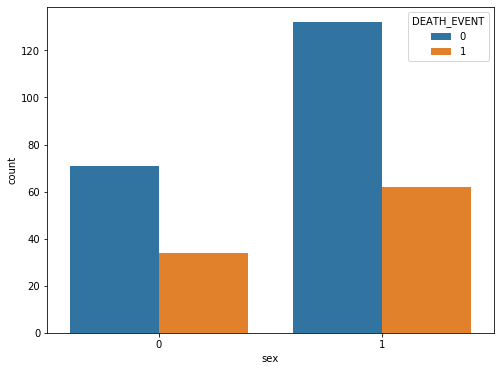

In [13]:
#kita lihat hubungan antara sex dan target
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="sex", hue="DEATH_EVENT", data=df)
plt.show()

kita juga bisa melihat disini pasien laki-laki lebih banyak yang terkena gagal jantung

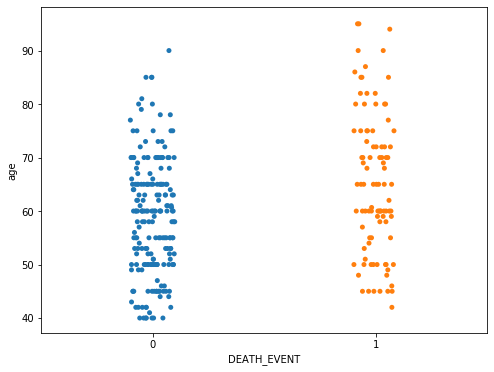

In [14]:
#hubungan target dengan age
f, ax = plt.subplots(figsize=(8, 6))
sns.stripplot(x="DEATH_EVENT", y="age", data=df)
plt.show()

Kita dapat melihat bahwa orang yang terkena gagal jantung dan orang yang tidak terkena gagal jantung memiliki usia yang sebanding.

In [15]:
# check for missing values

df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


Kita dapat melihat bahwa tidak ada missing value dalam dataset.

# Klasifikasi

Bagi dataset menjadi data latih dan data uji dengan rasio 70:30. Buang kolom `time` dari data dan gunakan `DEATH_EVENT` sebagai kelas yang akan diprediksi. 

## Dataset Splitting

In [16]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [17]:
X = df.drop(columns=["DEATH_EVENT", "time"])
y = df.DEATH_EVENT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((209, 11), (90, 11), (209,), (90,))

## Training

In [18]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
186,50.0,0,582,0,50,0,153000.0,0.6,138,0,0
258,45.0,1,66,1,25,0,233000.0,0.8,141,1,0
104,60.0,0,53,0,50,1,286000.0,2.3,136,0,0
161,45.0,1,130,0,35,0,174000.0,0.8,137,1,1
263,68.0,1,157,1,60,0,208000.0,1.0,141,0,0


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]),
    ('categoric', cat_pipe(encoder='onehot'), ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'algo__C': 0.1, 'algo__fit_intercept': True}
0.7464114832535885 0.7418219461697723 0.7777777777777778


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    3.8s finished


akurasi sudah cukup baik, tetapi masih bisa kita improve:


*   tambahkan scaling dan transform datanya
*   mencoba algoritma lain
*   bisa juga kita binning fitur age nya, mungkin data itu bisa menjadi lebih bermakna






In [21]:
#coba pakai scaling standard sama transform yeo johnson
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]),
    ('categoric', cat_pipe(encoder='onehot'), ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 10.0, 'algo__fit_intercept': True}
0.8564593301435407 0.8421670117322292 0.8444444444444444


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.9s finished


In [22]:
#coba algoritma lain
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [23]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson', poly=2), ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]),
    ('categoric', cat_pipe(encoder='onehot'), ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3,  n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   30.8s finished
C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:2970: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__max_depth': 27, 'algo__max_features': 0.5045056067243832, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 147, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': True}
1.0 0.8518288474810213 0.7777777777777778


ternyata hasil nya masih lebih bagus pakai algoritma logistic regression, karena jika soal klasifikasi seperti ini lebih cocok logistic regression

In [24]:
#coba tambahkan poly
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson', poly=2), ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]),
    ('categoric', cat_pipe(encoder='onehot'), ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 84 candidates, totalling 252 fits


C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:   17.0s finished
C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:2970: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 1.0, 'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.861244019138756 0.8518288474810215 0.8333333333333334


In [25]:
#coba kita binning dulu age nya
#dimana numeric menjadi categoric, dengan harapan jika jadi categoric akan lebih bermakna data tersebut
#min40, max95
df["age_category"] = pd.cut(df.age, [40, 50, 70, 95], labels=["dewasa", "lansia_awal", "lansia_akhir"])
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,age_category
0,75.0,0,582,0,20,1,265000.00,1.9,113,1,0,4,1,lansia_akhir
1,55.0,0,7861,0,38,0,263358.03,1.1,116,1,0,6,1,lansia_awal
2,65.0,0,146,0,20,0,162000.00,1.3,121,1,1,7,1,lansia_awal
3,50.0,1,111,0,20,0,210000.00,1.9,124,1,0,7,1,dewasa
4,65.0,1,160,1,20,0,327000.00,2.7,125,0,0,8,1,lansia_awal


In [26]:
df.age_category.value_counts()

lansia_awal     173
dewasa           67
lansia_akhir     52
Name: age_category, dtype: int64

In [27]:
X = df.drop(columns=["DEATH_EVENT", "time"])
y = df.DEATH_EVENT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((209, 12), (90, 12), (209,), (90,))

In [28]:
#pakai binningnya
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), ["creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]),
    ('categoric', cat_pipe(encoder='onehot'), ["age_category", "anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 0.1, 'algo__fit_intercept': False}
0.8708133971291866 0.8182194616977226 0.8333333333333334


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.7s finished


ternyata hasilnya tidak cukup baik dari model kedua kita tadi

In [29]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]),
    ('categoric', cat_pipe(encoder='onehot'), ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 10.0, 'algo__fit_intercept': True}
0.8564593301435407 0.8421670117322292 0.8444444444444444


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.7s finished


In [30]:
#Evaluation
from jcopml.plot import plot_confusion_matrix

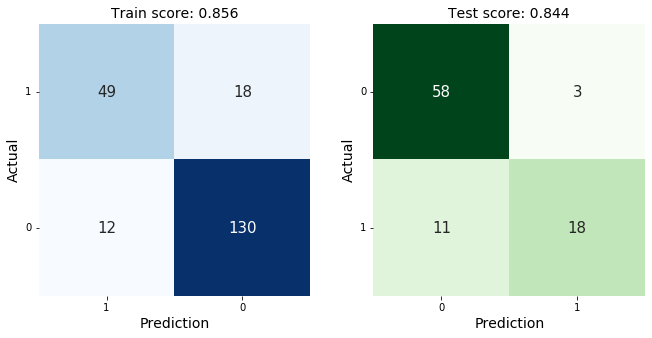

In [31]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

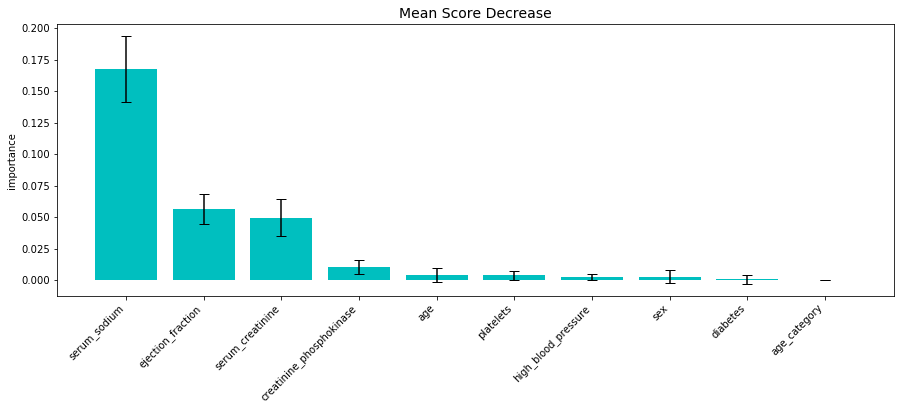

In [32]:
# Feature Importance
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [33]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), ["serum_sodium", "ejection_fraction", "serum_creatinine", "creatinine_phosphokinase", "age", "platelets"]),
    ('categoric', cat_pipe(encoder='onehot'), ["high_blood_pressure", "sex"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 10.0, 'algo__fit_intercept': True}
0.8660287081339713 0.8518288474810215 0.8333333333333334


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.7s finished


oke ternyata fiture importance tidak cukup membantu disini, maka kita gunakan model dibawah ini.

In [34]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]),
    ('categoric', cat_pipe(encoder='onehot'), ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\ASUS\Miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 10.0, 'algo__fit_intercept': True}
0.8564593301435407 0.8421670117322292 0.8444444444444444


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.7s finished
